# t-SNE Algorithm Implementation from Scratch

This notebook implements the t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm 
from scratch. t-SNE is a technique for dimensionality reduction that is particularly 
well suited for the visualization of high-dimensional datasets.

## 1. Introduction to t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality 
reduction technique well-suited for embedding high-dimensional data in a low-dimensional 
space (typically 2D or 3D for visualization). It was developed by Laurens van der Maaten 
and Geoffrey Hinton in 2008.

Key characteristics of t-SNE:
- Preserves local structure: Similar objects in high-dimensional space remain close in low-dimensional space
- Handles non-linear relationships better than PCA
- Reveals clusters at different scales
- Uses probability distributions to represent similarities between points

The main idea behind t-SNE is to convert similarities between data points to joint probabilities 
and minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional 
embedding and the high-dimensional data.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## 2. Loading and Preparing the Data

First, we'll load the HR_data.csv file and inspect its structure. We'll need to preprocess 
the data by selecting relevant features and normalizing them.

## 3. t-SNE Algorithm Theoretical Background

The t-SNE algorithm consists of two main steps:

1. **Convert high-dimensional Euclidean distances to conditional probabilities that represent similarities:**
   - For each point i, compute the conditional probability p(j|i) that point i would pick point j as its neighbor
   - These probabilities are proportional to a Gaussian probability density centered at point i:
     $$p(j|i)=\dfrac{e^\frac{-||x_i - x_j||^2}{2σ_i^2}}{\displaystyle\sum_{k\neq i}e^\frac{-||x_i - x_k||^2}{2σ_i^2}}$$
   - The variance σ_i of the Gaussian is chosen such that the perplexity of the conditional distribution equals a predefined value
   - Set $p(i|i)=0$ (a point cannot be its own neighbor)
   - Symmetrize the probabilities: $p_{ij}=\dfrac{p(j|i) + p(i|j)}{2n}$ to get joint probability distribution $P$

2. **Define a similar probability distribution in the low-dimensional map and minimize KL divergence:**
   - Define joint probabilities $q_{ij}$ in the low-dimensional space using Student t-distribution with one degree of freedom (heavier tails an Gaussian):
     $$q_{ij}=\dfrac{(1+||y_i - y_j||^2)^{-1}}{\displaystyle\sum_{k\ne l}(1+||y_k-y_l||^2)^{-1}}$$
   - Minimize the Kullback-Leibler divergence between P and Q: $$KL(P||Q) = ∑_{i≠j} p_{ij} log(p_{ij}/q_{ij})$$
   - Use gradient descent to find the optimal positions of points in low-dimensional space

The gradient of the KL divergence can be written as:
$$∇C = 4 ∑_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||²)^(-1)$$

t-SNE uses this gradient to update the positions of the points in the low-dimensional space.


## 4. t-SNE Implementation from Scratch

Now let's implement each step of the algorithm in detail.

### 4.1 Computing Pairwise Affinities (High-Dimensional Similarities)

First, we need to compute the conditional probability distributions p(j|i) in the high-dimensional space. 

The perplexity parameter can be interpreted as a smooth measure of the effective number of neighbors. 
It's related to the variance (σ²) of the Gaussian distribution used to calculate conditional probabilities.

In [23]:
def compute_pairwise_affinities(X, perplexity=30.0, tol=1e-5):
    """Compute pairwise affinities with automatic sigma selection."""
    n = X.shape[0]
    P = np.zeros((n, n))
    
    # Compute squared Euclidean distances
    sum_X = np.sum(np.square(X), axis=1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    
    # Add a small amount to the diagonal to prevent numerical issues
    np.fill_diagonal(D, 0.0)
    D = np.maximum(D, 0.0)  # Ensure no negative distances due to numerical errors
    
    print("Computing pairwise affinities...")
    for i in range(n):
        if i % 10 == 0:
            print(f"Processing point {i}/{n}")
            
        # Initialize variables for binary search
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0
        
        # Create indices array for all points except i
        indices = np.concatenate((np.arange(0, i), np.arange(i+1, n)))
        
        # Extract distances to all other points
        dist_i = D[i, indices]
        
        # Binary search for the right perplexity
        H_diff = 1.0  # Initialize difference from target perplexity
        tries = 0  # Count attempts
        
        while (H_diff > tol and tries < 50):
            # Compute conditional probabilities with current beta
            P_i = np.exp(-dist_i * beta)
            
            # Avoid numerical issues
            sum_P_i = np.maximum(np.sum(P_i), 1e-12)
            
            # Normalize
            P_i = P_i / sum_P_i
            
            # Compute entropy and perplexity
            H = -np.sum(P_i * np.log2(np.maximum(P_i, 1e-12)))
            H_diff = np.abs(2**H - perplexity)
            
            # Binary search update
            if 2**H > perplexity:
                # Increase precision (beta)
                beta_min = beta
                if beta_max == np.inf:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                # Decrease precision (beta)
                beta_max = beta
                if beta_min == -np.inf:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0
                    
            tries += 1
        
        # Store conditional probabilities
        P[i, indices] = P_i
    
    # Symmetrize and normalize the probability matrix
    P = (P + P.T) / (2.0 * n)
    
    # Add a small value to avoid numerical issues
    P = np.maximum(P, 1e-12)
    
    return P

### 4.2 Low-Dimensional Embedding Initialization

Next, we need to initialize the points in low-dimensional space. We can use random initialization 
or PCA for better starting positions.

In [24]:
def initialize_embedding(X, dim=2, method='random'):
    """Initialize the low-dimensional embedding."""
    n = X.shape[0]
    
    if method == 'random':
        # Random initialization with small values
        np.random.seed(42)  # For reproducibility
        Y = np.random.normal(0, 1e-4, size=(n, dim))
    elif method == 'pca':
        # PCA initialization (often leads to better results)
        from sklearn.decomposition import PCA
        pca = PCA(n_components=dim)
        Y = pca.fit_transform(X)
        Y = Y * 1e-4  # Scale down the values
    
    return Y

### 4.3 Low-Dimensional Similarities and Gradient Computation

Now we'll compute the similarities in the low-dimensional space using Student's t-distribution 
and compute the gradient for optimization.

In [25]:
def compute_low_dimensional_probabilities(Y):
    """Compute the joint probability distribution Q in low dimensional space."""
    n = Y.shape[0]
    
    # Compute squared Euclidean distances
    sum_Y = np.sum(np.square(Y), axis=1)
    D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
    D = np.maximum(D, 0)  # Ensure distances are non-negative due to numerical errors
    
    # Compute Q matrix using Student t-distribution (degrees of freedom = 1)
    Q = 1.0 / (1.0 + D)
    np.fill_diagonal(Q, 0)  # Set diagonal to zero
    
    # Normalize Q to create a probability distribution
    Q_sum = np.maximum(np.sum(Q), 1e-12)  # Avoid division by zero
    Q = Q / Q_sum
    
    # Add small value to avoid numerical issues
    Q = np.maximum(Q, 1e-12)
    
    return Q, D

In [26]:
def compute_gradient(P, Q, Y, D):
    """Compute the gradient of KL divergence between P and Q."""
    n = Y.shape[0]
    
    # Calculate the difference between P and Q
    PQ_diff = P - Q
    
    # Compute the weights for the gradient
    weights = PQ_diff * (1.0 / (1.0 + D))
    
    # Compute the gradient for each point
    dY = np.zeros_like(Y)
    for i in range(n):
        # Element-wise multiplication and sum
        dY[i] = 4.0 * np.sum(np.multiply(weights[i].reshape(-1, 1), (Y[i] - Y)), axis=0)
    
    return dY

### 4.4 Full t-SNE Implementation with Optimization

Finally, we'll combine all steps into a complete t-SNE algorithm using gradient descent 
with momentum for optimization.

In [27]:
def tsne(X, n_components=2, perplexity=30.0, n_iter=1000, learning_rate=200.0, momentum=0.5):
    """Perform t-SNE dimensionality reduction."""
    # Check input
    if isinstance(X, pd.DataFrame):
        X = X.values
    X = X.astype(np.float64)
    
    # Handle NaN values more robustly
    if np.isnan(X).any():
        print("Warning: Input contains NaN values. Filling with column means...")
        # First check if entire columns are NaN
        col_means = np.nanmean(X, axis=0)
        # Replace NaN means with 0 if entire column is NaN
        col_means = np.where(np.isnan(col_means), 0, col_means)
        
        # Fill NaN values with column means
        for i in range(X.shape[1]):
            mask = np.isnan(X[:, i])
            X[mask, i] = col_means[i]
            
        # Double-check that all NaNs are gone
        if np.isnan(X).any():
            print("Warning: Some NaN values could not be filled. Replacing with zeros...")
            X = np.nan_to_num(X, nan=0.0)
    
    # Initialize variables
    n_samples = X.shape[0]
    
    # Compute pairwise affinities
    P = compute_pairwise_affinities(X, perplexity)
    P = P * 4.0  # Early exaggeration
    
    # Initialize solution (PCA or random)
    try:
        if X.shape[1] > n_components:
            print("Initializing with PCA...")
            from sklearn.decomposition import PCA
            # Verify data is clean before PCA
            if np.isnan(X).any():
                raise ValueError("Data still contains NaN values after cleaning")
                
            pca = PCA(n_components=n_components)
            Y = pca.fit_transform(X)
            Y = Y * 0.0001  # Scale down the initial solution
            print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
        else:
            raise ValueError("Using random initialization instead")
    except Exception as e:
        print(f"PCA initialization failed: {e}")
        print("Using random initialization...")
        np.random.seed(42)  # For reproducibility
        Y = np.random.randn(n_samples, n_components) * 0.0001
    
    # Initialize optimization variables
    Y_prev = np.zeros_like(Y)
    gains = np.ones_like(Y)
    
    # Start gradient descent
    print("Starting gradient descent...")
    for iter in range(n_iter):
        # Compute Q distribution and distances
        sum_Y = np.sum(np.square(Y), axis=1)
        # Compute squared Euclidean distances (corrected)
        D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
        D = np.maximum(D, 0)  # Ensure distances are non-negative due to numerical errors
        
        # Compute Q matrix using Student t-distribution
        num = 1.0 / (1.0 + D)
        np.fill_diagonal(num, 0.0)
        Q = num / np.maximum(np.sum(num), 1e-12)
        
        # Add small value to avoid numerical issues
        Q = np.maximum(Q, 1e-12)
        
        # Compute gradient (vectorized implementation)
        PQ_diff = P - Q
        dY = np.zeros_like(Y)
        for i in range(n_samples):
            # Correct gradient calculation
            dY[i] = 4.0 * np.sum(np.multiply(PQ_diff[i].reshape(-1, 1) * num[i].reshape(-1, 1),
                                            (Y[i] - Y)), axis=0)
        
        # Update solution with gains and momentum
        gains = (gains + 0.2) * ((dY * (Y - Y_prev)) <= 0) + \
                gains * 0.8 * ((dY * (Y - Y_prev)) > 0)
        gains[gains < 0.01] = 0.01
        
        Y_prev = Y.copy()
        Y = Y - learning_rate * gains * dY + momentum * (Y - Y_prev)
        Y = Y - np.mean(Y, axis=0)  # Center
        
        # Print progress and check for convergence
        if iter == 100:
            P = P / 4.0  # Remove early exaggeration
        
        if iter % 50 == 0 or iter == n_iter - 1:
            cost = np.sum(P * np.log(np.maximum(P, 1e-12) / np.maximum(Q, 1e-12)))
            print(f"Iteration {iter}: cost = {cost}")
            
            # Print some statistics for debugging
            print(f"Y stats - mean: {np.mean(Y):.6f}, std: {np.std(Y):.6f}")
            print(f"grad stats - mean: {np.mean(dY):.6f}, std: {np.std(dY):.6f}")
            print(f"gains stats - mean: {np.mean(gains):.6f}, std: {np.std(gains):.6f}")
    
    return Y

## 5. Executing t-SNE and Visualizing Results

In the `__main__` section at the bottom of this file, we run our t-SNE implementation 
on a dataset and visualize the results.

In [28]:
def find_best_perplexity(X, perplexity_range=None, n_components=3, n_iter=5000, learning_rate=10.0, momentum=0.8):
    """
    Try multiple perplexity values and plot the results to help find the optimal value.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input data.
    perplexity_range : list or None
        List of perplexity values to try. If None, uses [5, 10, 30, 50, 100].
    n_components : int
        Number of components for t-SNE.
    n_iter : int
        Number of iterations.
    learning_rate : float
        Learning rate for t-SNE.
    momentum : float
        Momentum for t-SNE.
    
    Returns:
    --------
    dict : Dictionary mapping perplexity values to resulting embeddings.
    """
    if perplexity_range is None:
        # Use a range of perplexity values, ensuring they don't exceed the dataset size
        max_perp = min(100, X.shape[0] // 3)
        perplexity_range = [5, 10, 30, min(50, max_perp), min(100, max_perp)]
        # Remove duplicates and sort
        perplexity_range = sorted(list(set(perplexity_range)))
    
    results = {}
    
    # Calculate embeddings for each perplexity
    print("\nFinding optimal perplexity value...")
    for perplexity in perplexity_range:
        print(f"Computing t-SNE with perplexity = {perplexity}")
        start_time = time.time()
        Y = tsne(X, n_components=n_components, perplexity=perplexity, n_iter=n_iter, learning_rate=learning_rate, momentum=momentum)
        end_time = time.time()
        print(f"t-SNE execution time: {end_time - start_time:.2f} seconds")
        
        results[perplexity] = Y
    
    if n_components == 2:
        n_plots = len(perplexity_range)
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        plt.figure(figsize=(n_cols * 5, n_rows * 4))
        
        for i, perplexity in enumerate(perplexity_range):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.scatter(results[perplexity][:, 0], results[perplexity][:, 1], s=30, alpha=0.7)
            plt.title(f'Perplexity = {perplexity}')
            plt.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('tsne_perplexity_comparison_2d.png', dpi=300)
        plt.show()
    
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        
        n_plots = len(perplexity_range)
        n_cols = min(3, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols
        
        fig = plt.figure(figsize=(n_cols * 6, n_rows * 5))
        
        for i, perplexity in enumerate(perplexity_range):
            ax = fig.add_subplot(n_rows, n_cols, i + 1, projection='3d')
            ax.scatter(results[perplexity][:, 0], results[perplexity][:, 1], results[perplexity][:, 2], s=30, alpha=0.7)
            ax.set_title(f'Perplexity = {perplexity}')
            ax.grid(alpha=0.3)
            ax.view_init(30, 45)
        
        plt.tight_layout()
        plt.savefig('tsne_perplexity_comparison_3d.png', dpi=300)
        plt.show()
    
    print("\nPerplexity optimization complete!")
    print("The 'best' perplexity value is subjective and depends on what structure you're trying to reveal.")
    print("Look for a visualization where:")
    print("- Similar data points are grouped together")
    print("- Dissimilar data points are far apart")
    print("- The structure matches your prior knowledge about the data")
    print("- There's a balance between local and global structure")

    return results

## 6. Optimization and Discussion

### Computational Complexity

t-SNE has a computational complexity of O(n²) where n is the number of data points. 
This makes it challenging to use with very large datasets. Several optimizations can be made:

1. **Barnes-Hut approximation**: Reduces complexity to O(n log n) by approximating similarities between distant points
2. **Using PCA as preprocessing**: Reduces the dimensionality before applying t-SNE
3. **Faster implementation with accelerated computation**: Using libraries like Numba or parallel computing

### Parameter Tuning

Key parameters in t-SNE that affect the results:

1. **Perplexity**: Controls the balance between preserving local vs. global structure (typically between 5-50)
2. **Learning rate**: Too high can cause instability, too low can cause slow convergence
3. **Number of iterations**: Enough iterations are needed for convergence (typically 1000+)
4. **Early exaggeration factor**: Higher values help to form more separated clusters

### Limitations of t-SNE

1. **Stochastic nature**: Different runs can produce different results
2. **No meaningful global structure**: Distances between clusters may not be meaningful
3. **Crowding problem**: In very high dimensions, points that are far apart can end up crowded in the low-dimensional space
4. **Computationally expensive** for large datasets

### Interpretation of Results

When interpreting t-SNE visualizations:
- **Focus on clusters**: Look for groupings of points
- **Don't overinterpret distances between clusters**: The global arrangement is less reliable
- **Compare with other methods**: Use alongside PCA or UMAP for a more complete picture
- **Use multiple perplexity values**: Results can be sensitive to this parameter

## 7. Comparison with sklearn Implementation (Optional)

For comparison, we can also use the scikit-learn implementation of t-SNE.

## 8. Conclusion

We've implemented the t-SNE algorithm from scratch and applied it to the HR dataset. 
The implementation includes:

1. Computing high-dimensional probabilities using a Gaussian kernel
2. Computing low-dimensional probabilities using a Student's t-distribution
3. Minimizing the KL divergence between these distributions via gradient descent

The visualization shows how points cluster in the reduced space, which can help identify 
patterns and structure in the HR data.

This implementation serves as a learning tool to understand the inner workings of t-SNE. 
For production use, optimized implementations from libraries like scikit-learn are 
recommended for efficiency and robustness.

In [29]:
feature_path = '../Preprocessing/HR_features_scaled.csv'
feature_data = pd.read_csv(feature_path)
print(f"Successfully loaded data from {feature_path}")
print(f"Dataset shape: {feature_data.shape}")

feature_columns = feature_data.select_dtypes(include=np.number).columns.tolist()

print(f"\nUsing {len(feature_columns)} features for t-SNE:")
print(feature_columns)

X = feature_data[feature_columns].to_numpy()

indices = np.arange(X.shape[0])
sample_size = X.shape[0]


targets_path = '../Preprocessing/HR_targets_scaled.csv'
targets_data = pd.read_csv(targets_path)
print(f"Successfully loaded data from {targets_path}")
print(f"Dataset shape: {targets_data.shape}")

targets_columns = targets_data.select_dtypes(include=np.number).columns.tolist()

print(f"\nUsing {len(targets_columns)} features for t-SNE:")
print(targets_columns)

Z = targets_data[targets_columns].to_numpy()

Successfully loaded data from ../Preprocessing/HR_features_scaled.csv
Dataset shape: (312, 51)

Using 51 features for t-SNE:
['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT


Running t-SNE on 312 samples with 51 features

Finding optimal perplexity value...
Computing t-SNE with perplexity = 5
Computing pairwise affinities...
Processing point 0/312
Processing point 10/312
Processing point 20/312
Processing point 30/312
Processing point 40/312
Processing point 50/312
Processing point 60/312
Processing point 70/312
Processing point 80/312
Processing point 90/312
Processing point 100/312
Processing point 110/312
Processing point 120/312
Processing point 130/312
Processing point 140/312
Processing point 150/312
Processing point 160/312
Processing point 170/312
Processing point 180/312
Processing point 190/312
Processing point 200/312
Processing point 210/312
Processing point 220/312
Processing point 230/312
Processing point 240/312
Processing point 250/312
Processing point 260/312
Processing point 270/312
Processing point 280/312
Processing point 290/312
Processing point 300/312
Processing point 310/312
Initializing with PCA...
Explained variance ratio: [0.2781

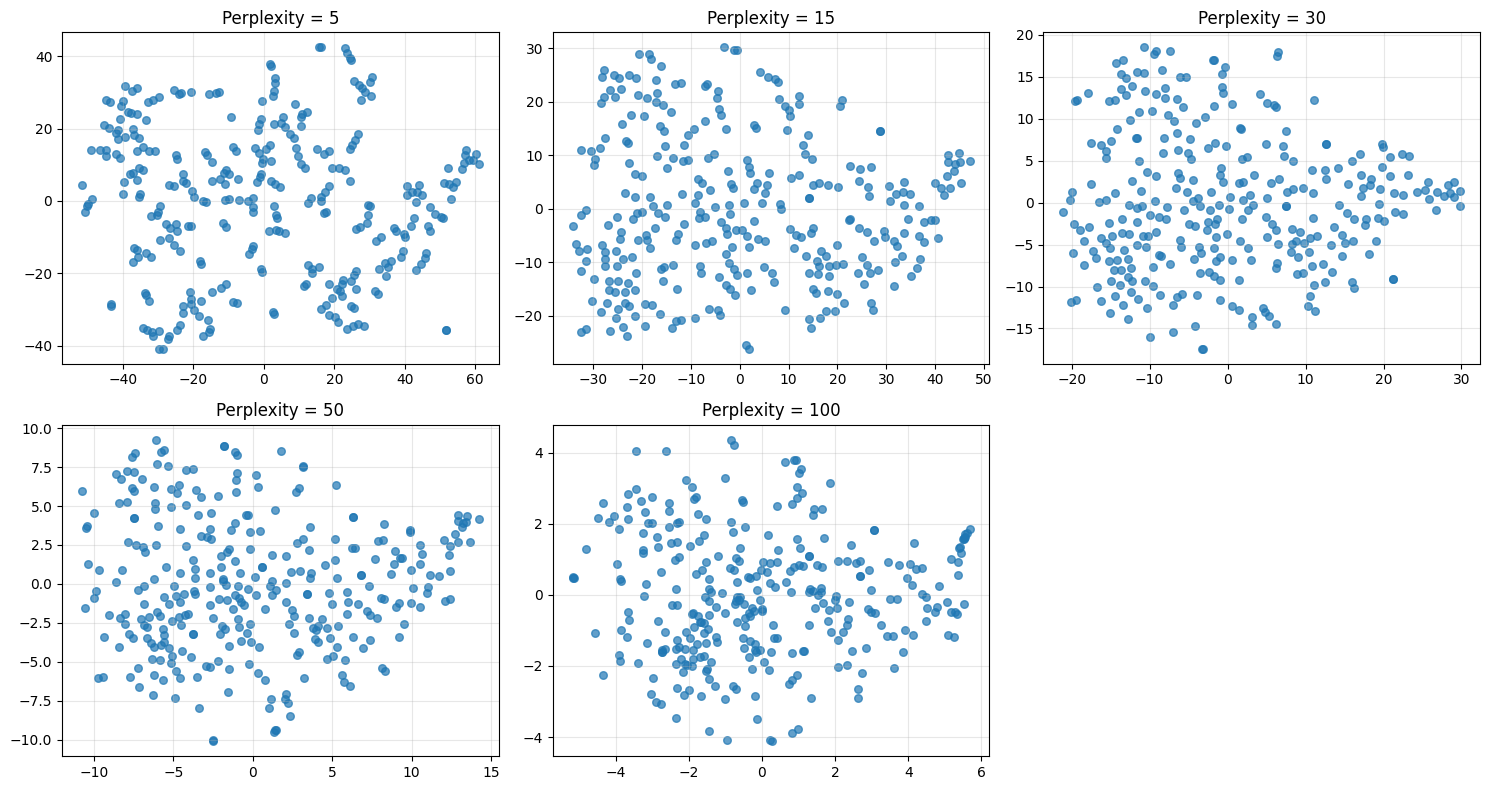


Perplexity optimization complete!
The 'best' perplexity value is subjective and depends on what structure you're trying to reveal.
Look for a visualization where:
- Similar data points are grouped together
- Dissimilar data points are far apart
- The structure matches your prior knowledge about the data
- There's a balance between local and global structure


In [30]:
print(f"\nRunning t-SNE on {X.shape[0]} samples with {X.shape[1]} features")

# Find the best perplexity value
n_components = 2  # Set to 2 or 3 based on your preference
perplexity_values = [5, 15, 30, 50, 100]

results = find_best_perplexity(
    X, 
    perplexity_range=perplexity_values,
    n_components=n_components,
    n_iter=3000,
    learning_rate=100.0,
    momentum=0.9
)


Creating final visualization with perplexity = 100


ValueError: 'c' argument has 11 elements, which is inconsistent with 'x' and 'y' with size 312.

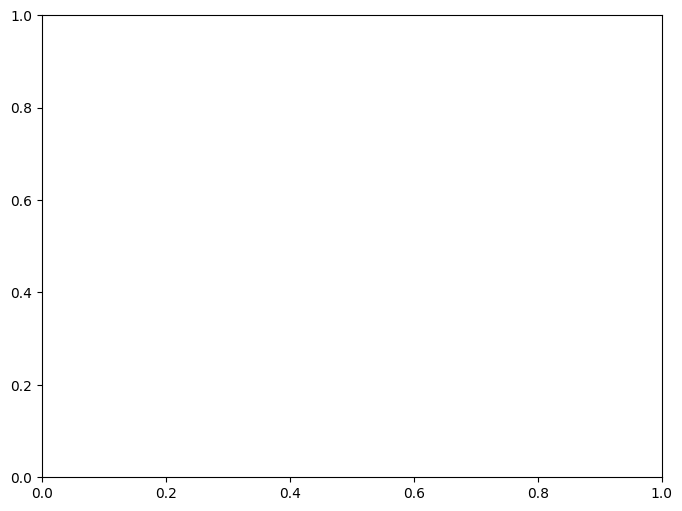

In [41]:
# Get the embedding for the highest perplexity (usually gives the best global structure)
# You can also choose a different perplexity based on the plots
Y = results[perplexity_values[-1]]

# Now visualize the final result with the chosen perplexity
print(f"\nCreating final visualization with perplexity = {perplexity_values[-1]}")

if n_components == 3:
    # Visualize the results in 3D
    from mpl_toolkits.mplot3d import Axes3D
    
    plt.figure(figsize=(14, 12))
    ax = plt.axes(projection='3d')
    
    point_size = max(10, min(50, 1000 // sample_size))

    # Color points by target if available
    if 'Frustrated' in Z.columns:
        target_values = Z['Frustrated'].values[np.arange(Z.shape[0])]
        scatter = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=target_values, cmap='viridis', s=point_size, alpha=0.7)
        plt.colorbar(scatter, label='Frustrated')
        plt.title(f'3D t-SNE Visualization (Perplexity={perplexity_values[-1]}) - All {sample_size} data points')
    
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.set_zlabel('t-SNE dimension 3')
    
    # Add a grid
    ax.grid(alpha=0.3)
    
    # Add rotation for better 3D visualization
    ax.view_init(30, 45)
    plt.savefig(f'tsne_result_final_3d.png', dpi=300)
        
    plt.tight_layout()
    plt.show()
else:
    # 2D visualization
    plt.figure(figsize=(8, 6))
    
    point_size = max(10, min(50, 1000 // sample_size))

    # Color points by target if available
    if 'Frustrated' in targets_columns:
        target_values = Z[targets_columns.index('Frustrated')]
        scatter = plt.scatter(Y[:, 0], Y[:, 1], c=target_values, cmap='viridis', s=point_size, alpha=0.7)
        plt.colorbar(scatter, label='Frustrated')
        plt.title(f'2D t-SNE Visualization (Perplexity={perplexity_values[-1]}) - All {sample_size} data points')
    
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'tsne_result_final_2d.png', dpi=300)
    plt.show()

C:\Users\longo\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\longo\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^

sklearn t-SNE execution time: 0.98 seconds


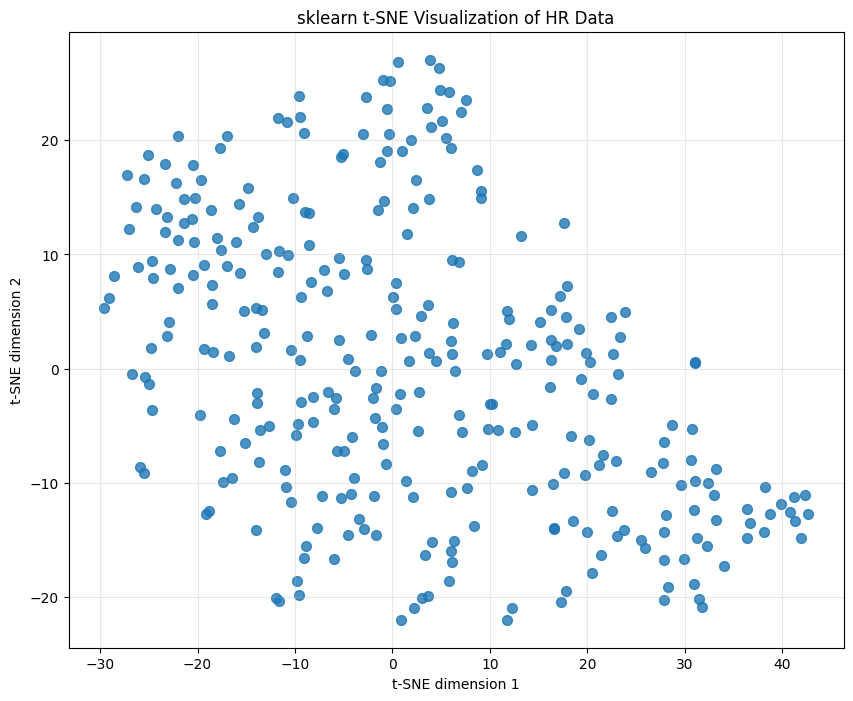

In [21]:
from sklearn.manifold import TSNE

# Run sklearn's t-SNE
start_time = time.time()
tsne_sklearn = TSNE(n_components=2, perplexity=15.0, random_state=42)
Y_sklearn = tsne_sklearn.fit_transform(X)
end_time = time.time()
print(f"sklearn t-SNE execution time: {end_time - start_time:.2f} seconds")

# Visualize sklearn results
plt.figure(figsize=(10, 8))
if 'Individual' in data.columns:
    individual_values = data['Individual'].values[:sample_size]
    scatter = plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=individual_values, cmap='viridis', s=50, alpha=0.8)
    plt.colorbar(scatter, label='Individual')
else:
    plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], s=50, alpha=0.8)

plt.title('sklearn t-SNE Visualization of HR Data')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(alpha=0.3)
plt.show()